Predicting Hotel Booking Cancellations

Machine Learning for Tourism applications

Install required libraries: 
```{python}
pip install imblearn xgboost
```

## Learning objectives:
1. Prepare hotel booking data for classification tasks
2. Implement and compare multiple classification algorithms
3. Handle class imbalance in tourism datasets
4. Evaluate model performance with appropriate metrics
5. Interpret models for business insights

In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

# For model interpretation
import shap

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Data Loading and Exploration

In [17]:
# Load the dataset
# Note: Assumes hotel_bookings.csv is in the current directory or path
# Dataset source: https://www.kaggle.com/jessemostipak/hotel-booking-demand
df = pd.read_csv('hotel_bookings.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst 5 rows of the dataset:")
display(df.head())

Dataset shape: (119390, 32)

First 5 rows of the dataset:


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [18]:
# Check for missing values
print("\nMissing values per column:")
display(df.isnull().sum().sort_values(ascending=False).head())


Missing values per column:


company               112593
agent                  16340
country                  488
children                   4
reserved_room_type         0
dtype: int64

In [19]:
# Basic statistics
print("\nBasic statistics for numerical columns:")
display(df.describe().T)


Basic statistics for numerical columns:


,count,mean,std,min,25%,50%,75%,max
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
arrival_date_year,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
arrival_date_week_number,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
arrival_date_day_of_month,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
stays_in_weekend_nights,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
stays_in_week_nights,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


In [20]:
#TODO: Explore with ydata_profiling.ProfileReport 

## 2. Data Visualization

Text(0, 0.5, 'Count')

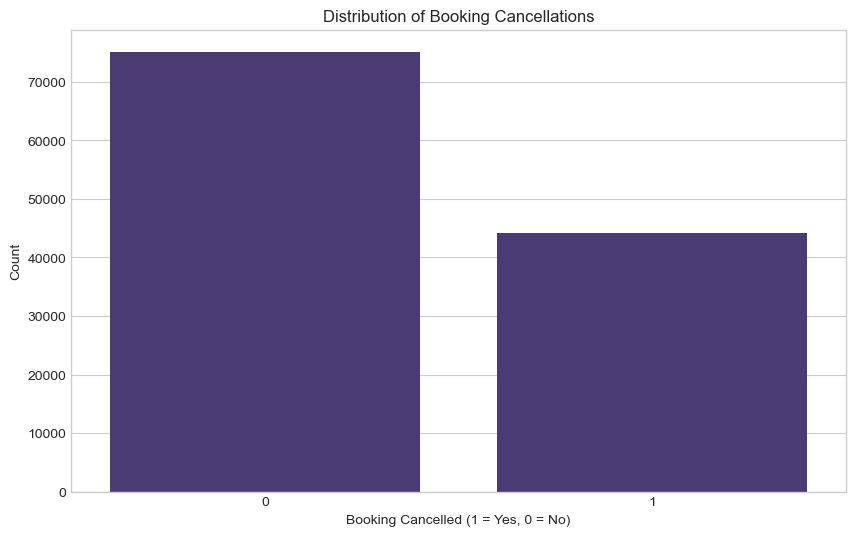

In [21]:
# Check class distribution (cancelled vs. not cancelled)
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='is_canceled', data=df)
plt.title('Distribution of Booking Cancellations')
plt.xlabel('Booking Cancelled (1 = Yes, 0 = No)')
plt.ylabel('Count')

In [22]:
# Add percentage labels
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

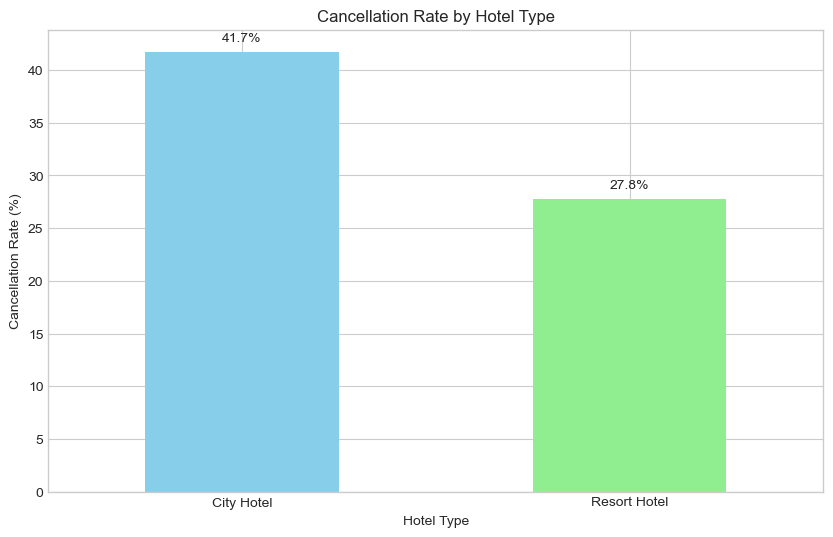

In [23]:
# Cancellation rate by hotel type
plt.figure(figsize=(10, 6))
hotel_cancel = df.groupby('hotel')['is_canceled'].mean() * 100
hotel_cancel.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Cancellation Rate by Hotel Type')
plt.xlabel('Hotel Type')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=0)

for i, v in enumerate(hotel_cancel):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.show()

C:\Users\Oscar\AppData\Local\Temp\ipykernel_20488\1362787773.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lead_cancel = df.groupby('lead_time_bins')['is_canceled'].mean() * 100


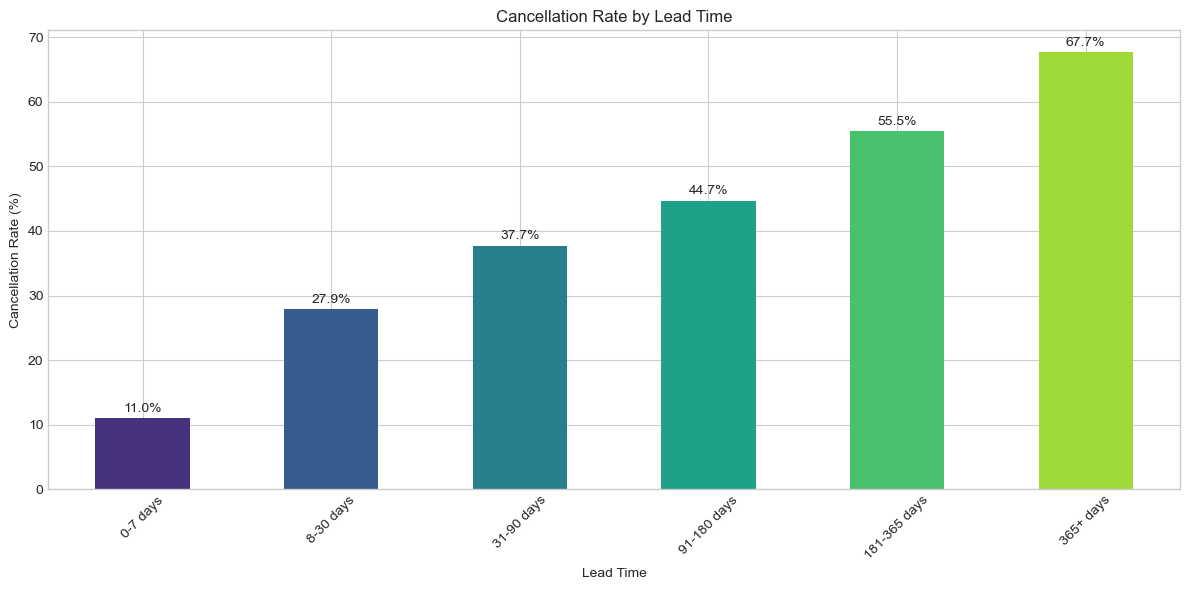

In [24]:
# Cancellation rate by lead time (binned)
df['lead_time_bins'] = pd.cut(df['lead_time'], 
                              bins=[0, 7, 30, 90, 180, 365, df['lead_time'].max()],
                              labels=['0-7 days', '8-30 days', '31-90 days', 
                                     '91-180 days', '181-365 days', '365+ days'])

plt.figure(figsize=(12, 6))
lead_cancel = df.groupby('lead_time_bins')['is_canceled'].mean() * 100
lead_cancel.plot(kind='bar', color=sns.color_palette("viridis", 6))
plt.title('Cancellation Rate by Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)

for i, v in enumerate(lead_cancel):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

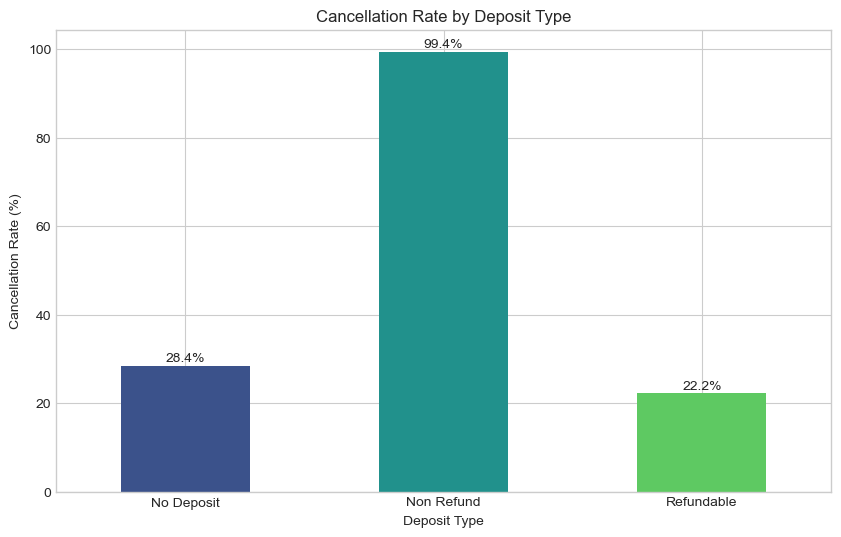

In [25]:
# Cancellation rate by deposit type
plt.figure(figsize=(10, 6))
deposit_cancel = df.groupby('deposit_type')['is_canceled'].mean() * 100
deposit_cancel.plot(kind='bar', color=sns.color_palette("viridis", 3))
plt.title('Cancellation Rate by Deposit Type')
plt.xlabel('Deposit Type')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=0)

for i, v in enumerate(deposit_cancel):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.show()

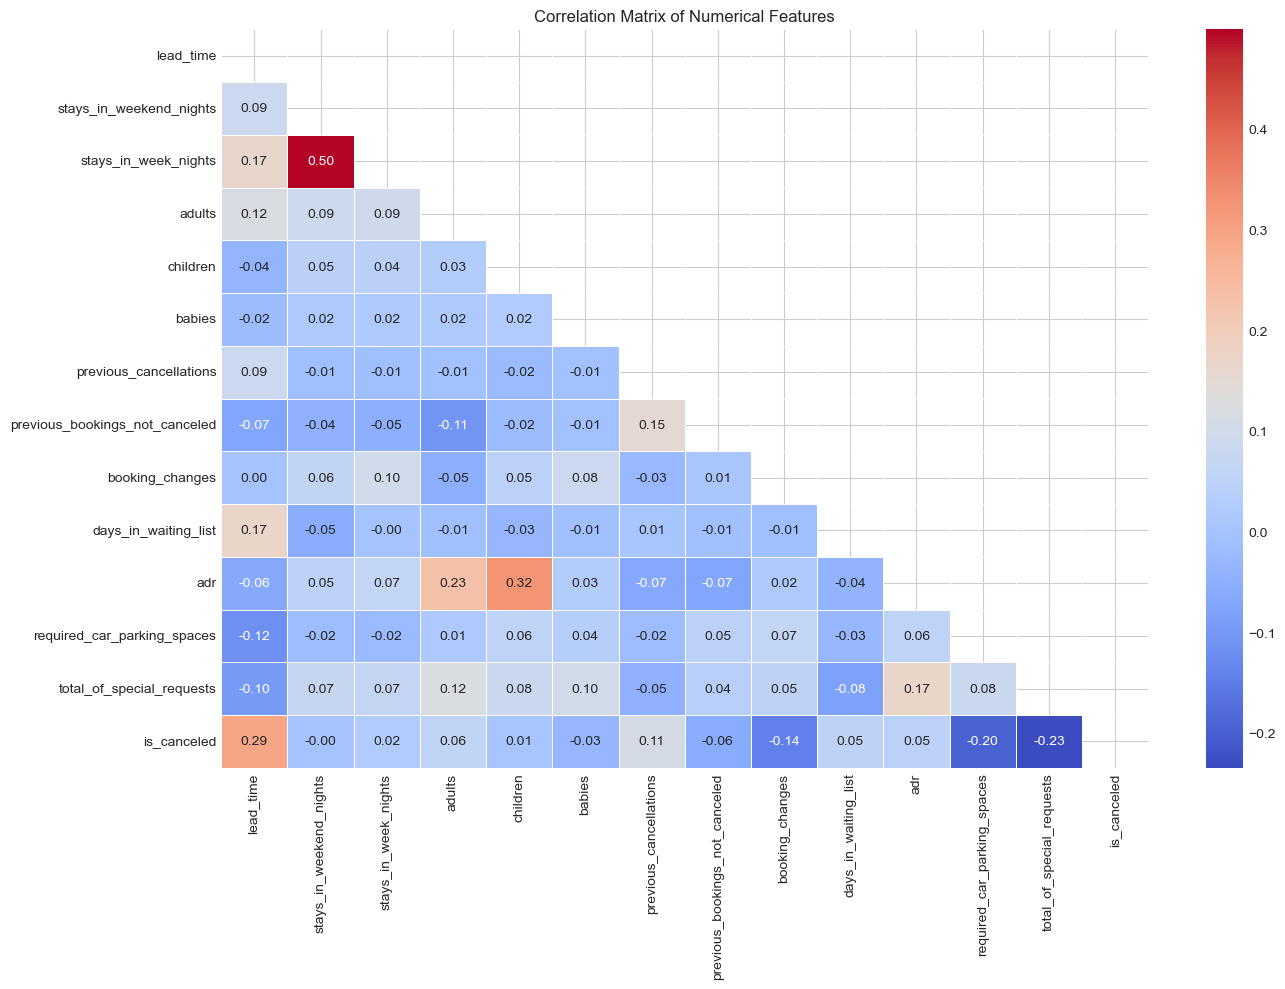

In [26]:
# Correlation analysis for numerical features
numerical_features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
                     'adults', 'children', 'babies', 'previous_cancellations',
                     'previous_bookings_not_canceled', 'booking_changes',
                     'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
                     'total_of_special_requests', 'is_canceled']

plt.figure(figsize=(14, 10))
correlation_matrix = df[numerical_features].corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            mask=mask, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [27]:
# Create a copy to avoid modifying the original dataframe
df_processed = df.copy()

# Create total nights feature
df_processed['total_nights'] = df_processed['stays_in_weekend_nights'] + df_processed['stays_in_week_nights']

# Create total guests feature
df_processed['total_guests'] = df_processed['adults'] + df_processed['children'] + df_processed['babies']

# Create average daily rate per person
df_processed['adr_per_person'] = df_processed['adr'] / df_processed['total_guests']
df_processed['adr_per_person'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_processed['adr_per_person'].fillna(df_processed['adr'], inplace=True)

# Extract arrival month, day of week and season
df_processed['arrival_date_month'] = pd.Categorical(df_processed['arrival_date_month'],
                                                  categories=['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December'],
                                                  ordered=True)
df_processed['arrival_month'] = df_processed['arrival_date_month'].cat.codes + 1

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_processed['season'] = df_processed['arrival_month'].apply(get_season)

# Create binary features
df_processed['is_repeated_guest'] = df_processed['is_repeated_guest'].astype(int)
df_processed['has_booking_changes'] = (df_processed['booking_changes'] > 0).astype(int)
df_processed['has_special_requests'] = (df_processed['total_of_special_requests'] > 0).astype(int)

# Handle categorical variables that need to be simplified
df_processed['market_segment'] = df_processed['market_segment'].replace('TA', 'Travel Agent')
df_processed['market_segment'] = df_processed['market_segment'].replace('TO', 'Tour Operator')

# Create a flag for high cancellation risk months (if any found from EDA)
monthly_cancellation = df_processed.groupby('arrival_month')['is_canceled'].mean()
high_cancel_months = monthly_cancellation[monthly_cancellation > monthly_cancellation.mean()].index.tolist()
df_processed['high_cancel_month'] = df_processed['arrival_month'].isin(high_cancel_months).astype(int)

df_processed

C:\Users\Oscar\AppData\Local\Temp\ipykernel_20488\2233321324.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['adr_per_person'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_20488\2233321324.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reservation_status_date,lead_time_bins,total_nights,total_guests,adr_per_person,arrival_month,season,has_booking_changes,has_special_requests,high_cancel_month
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,2015-07-01,181-365 days,0,2.0,0.000000,7,Summer,1,0,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,2015-07-01,365+ days,0,2.0,0.000000,7,Summer,1,0,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,2015-07-02,0-7 days,1,1.0,75.000000,7,Summer,0,0,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,2015-07-02,8-30 days,1,1.0,75.000000,7,Summer,0,0,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,2015-07-03,8-30 days,2,2.0,49.000000,7,Summer,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,2017-09-06,8-30 days,7,2.0,48.070000,8,Summer,0,0,1
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,2017-09-07,91-180 days,7,3.0,75.143333,8,Summer,0,1,1
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,2017-09-07,31-90 days,7,2.0,78.855000,8,Summer,0,1,1
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,2017-09-07,91-180 days,7,2.0,52.200000,8,Summer,0,0,1


In [28]:
# Drop columns we don't need
columns_to_drop = ['reservation_status', 'reservation_status_date', 'arrival_date_year',
                   'arrival_date_week_number', 'arrival_date_day_of_month', 'agent', 'company',
                   'lead_time_bins']
df_processed = df_processed.drop(columns_to_drop, axis=1, errors='ignore')

In [29]:
# Handle missing values
df_processed['children'].fillna(0, inplace=True)
df_processed['country'].fillna('Unknown', inplace=True)

# Keep only essential columns for modeling
essential_columns = ['hotel', 'is_canceled', 'lead_time', 'arrival_month', 'season',
                    'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights',
                    'adults', 'children', 'babies', 'total_guests', 'meal',
                    'market_segment', 'distribution_channel', 'is_repeated_guest',
                    'previous_cancellations', 'previous_bookings_not_canceled',
                    'reserved_room_type', 'assigned_room_type', 'booking_changes',
                    'deposit_type', 'days_in_waiting_list', 'customer_type',
                    'adr', 'adr_per_person', 'required_car_parking_spaces',
                    'total_of_special_requests', 'has_booking_changes', 'has_special_requests',
                    'high_cancel_month']

df_model = df_processed[essential_columns]

# Display processed data
print("Processed dataframe shape:", df_model.shape)
df_model.head()

Processed dataframe shape: (119390, 31)


C:\Users\Oscar\AppData\Local\Temp\ipykernel_20488\3123958510.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['children'].fillna(0, inplace=True)
C:\Users\Oscar\AppData\Local\Temp\ipykernel_20488\3123958510.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

,hotel,is_canceled,lead_time,arrival_month,season,stays_in_weekend_nights,stays_in_week_nights,total_nights,adults,children,...,deposit_type,days_in_waiting_list,customer_type,adr,adr_per_person,required_car_parking_spaces,total_of_special_requests,has_booking_changes,has_special_requests,high_cancel_month
0,Resort Hotel,0,342,7,Summer,0,0,0,2,0.0,...,No Deposit,0,Transient,0.0,0.0,0,0,1,0,1
1,Resort Hotel,0,737,7,Summer,0,0,0,2,0.0,...,No Deposit,0,Transient,0.0,0.0,0,0,1,0,1
2,Resort Hotel,0,7,7,Summer,0,1,1,1,0.0,...,No Deposit,0,Transient,75.0,75.0,0,0,0,0,1
3,Resort Hotel,0,13,7,Summer,0,1,1,1,0.0,...,No Deposit,0,Transient,75.0,75.0,0,0,0,0,1
4,Resort Hotel,0,14,7,Summer,0,2,2,2,0.0,...,No Deposit,0,Transient,98.0,49.0,0,1,0,1,1


## 4. Data Preparation for Modeling

In [30]:
# Define features and target
X = df_model.drop('is_canceled', axis=1)
y = df_model['is_canceled']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("\nNumerical columns:", numerical_cols)

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

Training set: 95512 samples
Test set: 23878 samples

Categorical columns: ['hotel', 'season', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']

Numerical columns: ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights', 'adults', 'children', 'babies', 'total_guests', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'adr_per_person', 'required_car_parking_spaces', 'total_of_special_requests']


## 5. Model Building: Logistic Regression

In [31]:
# Create a Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'total_nights', 'adults',
                                                   'children', 'babies',
                                                   'total_guests',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_...
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel', 'season', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [32]:
# Predict on test set
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n--- Logistic Regression Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")


--- Logistic Regression Performance ---
Accuracy: 0.8118
Precision: 0.8308
Recall: 0.6178
F1 Score: 0.7086
ROC AUC: 0.8615


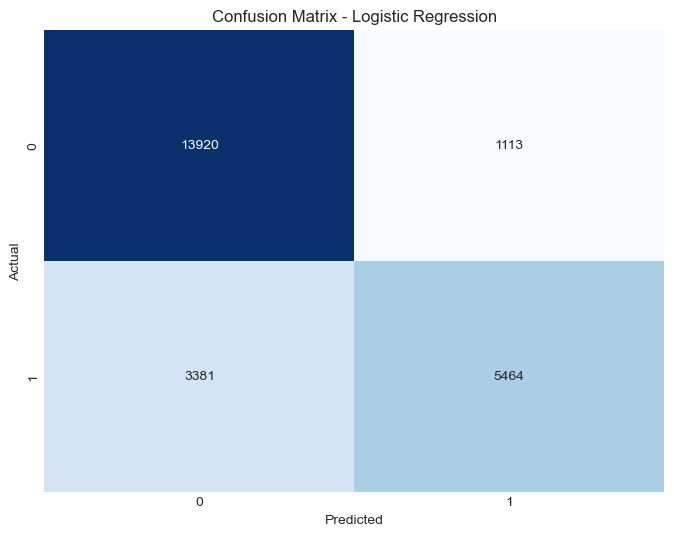

In [33]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

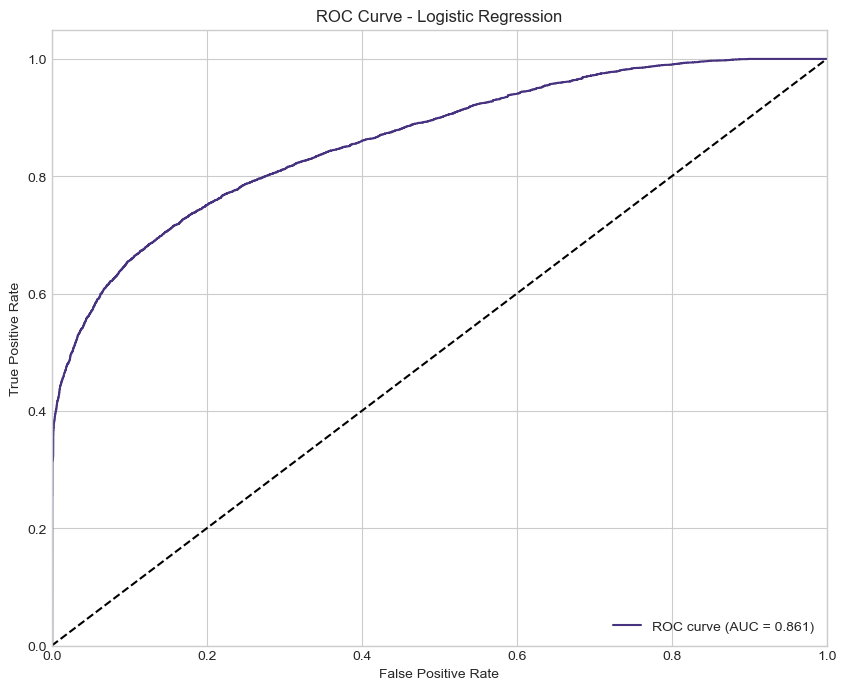

In [34]:

# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_lr):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

## 6. Model Building: Decision Tree

In [35]:
# Create a Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train the model
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'total_nights', 'adults',
                                                   'children', 'babies',
                                                   'total_guests',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_...
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel', 'season', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [36]:
# Predict on test set
y_pred_dt = dt_pipeline.predict(X_test)
y_pred_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n--- Decision Tree Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")


--- Decision Tree Performance ---
Accuracy: 0.8167
Precision: 0.7499
Recall: 0.7579
F1 Score: 0.7539
ROC AUC: 0.8081


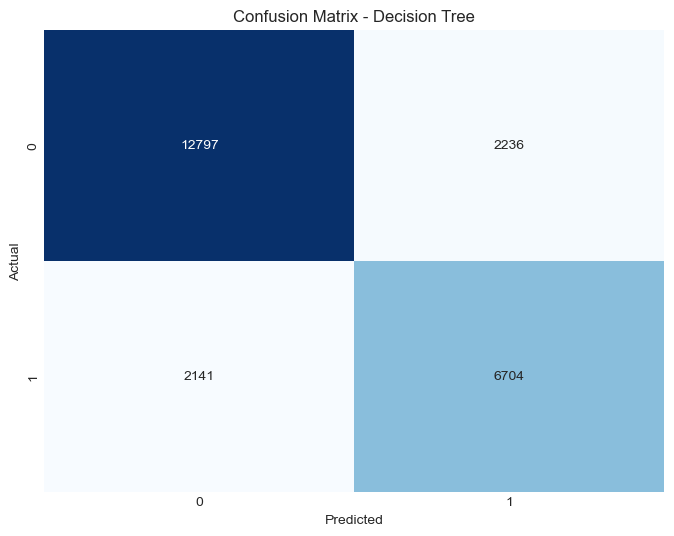

In [37]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Decision Tree')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

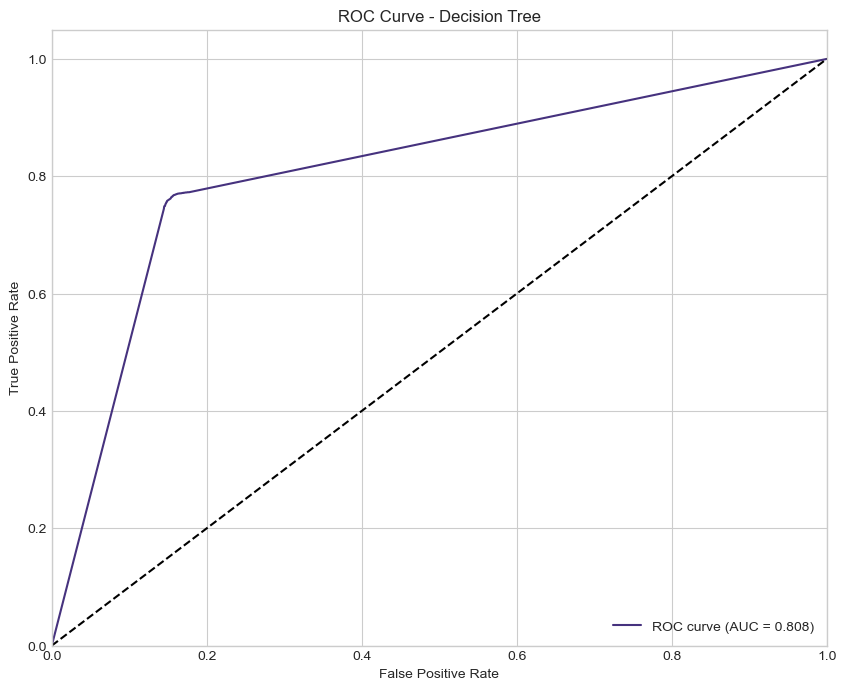

In [38]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_dt)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_dt):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()

## 7. Model Building: Random Forest

In [39]:
# Create a Random Forest pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'total_nights', 'adults',
                                                   'children', 'babies',
                                                   'total_guests',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_...
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel', 'season', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [40]:
# Predict on test set
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n--- Random Forest Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


--- Random Forest Performance ---
Accuracy: 0.8617
Precision: 0.8524
Recall: 0.7578
F1 Score: 0.8023
ROC AUC: 0.9256


## 8. Model Building: Gradient Boosting

In [41]:
# Create a Gradient Boosting pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
])

# Train the model
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'total_nights', 'adults',
                                                   'children', 'babies',
                                                   'total_guests',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_...
                                                   'total_of_special_requests']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel', 'season', 'meal',
                                                   'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [42]:

# Predict on test set
y_pred_gb = gb_pipeline.predict(X_test)
y_pred_proba_gb = gb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n--- Gradient Boosting Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")


--- Gradient Boosting Performance ---
Accuracy: 0.8203
Precision: 0.8604
Recall: 0.6146
F1 Score: 0.7170
ROC AUC: 0.8884


## 9. Model Building: XGBoost

In [43]:
# Create an XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'total_nights', 'adults',
                                                   'children', 'babies',
                                                   'total_guests',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [44]:

# Predict on test set
y_pred_xgb = xgb_pipeline.predict(X_test)
y_pred_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n--- XGBoost Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")


--- XGBoost Performance ---
Accuracy: 0.8435
Precision: 0.8482
Recall: 0.7032
F1 Score: 0.7689
ROC AUC: 0.9137


## 10. Model Comparison

In [45]:
# Compare all models
models = {
    'Logistic Regression': (y_pred_lr, y_pred_proba_lr),
    'Decision Tree': (y_pred_dt, y_pred_proba_dt),
    'Random Forest': (y_pred_rf, y_pred_proba_rf),
    'Gradient Boosting': (y_pred_gb, y_pred_proba_gb),
    'XGBoost': (y_pred_xgb, y_pred_proba_xgb)
}

# Create a comparison dataframe
comparison = pd.DataFrame(index=models.keys(), 
                         columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

for model_name, (y_pred, y_pred_proba) in models.items():
    comparison.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    comparison.loc[model_name, 'Precision'] = precision_score(y_test, y_pred)
    comparison.loc[model_name, 'Recall'] = recall_score(y_test, y_pred)
    comparison.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred)
    comparison.loc[model_name, 'ROC AUC'] = roc_auc_score(y_test, y_pred_proba)

# Sort by F1 Score
comparison = comparison.sort_values('F1 Score', ascending=False)

# Display comparison
print("\n--- Model Comparison ---")
print(comparison)


--- Model Comparison ---
                     Accuracy Precision    Recall  F1 Score   ROC AUC
Random Forest        0.861672  0.852365  0.757829  0.802322  0.925571
XGBoost              0.843454   0.84822  0.703222  0.768945  0.913668
Decision Tree        0.816693  0.749888  0.757942  0.753894   0.80812
Gradient Boosting    0.820295  0.860399  0.614585  0.717009   0.88841
Logistic Regression  0.811793  0.830774   0.61775  0.708598  0.861496


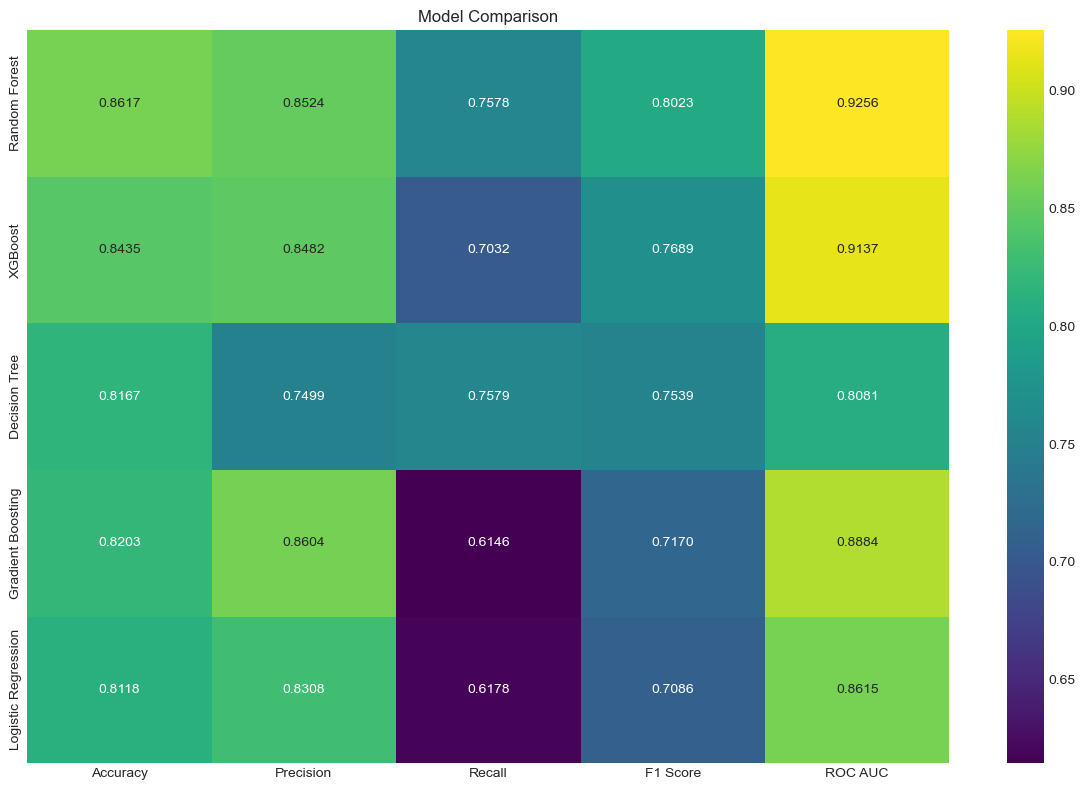

In [46]:

# convert comparison dataframe to float format
comparison = comparison.astype(float)

# Visualize comparison
plt.figure(figsize=(12, 8))
sns.heatmap(comparison, annot=True, cmap='viridis', fmt='.4f')
plt.title('Model Comparison')
plt.tight_layout()
plt.show()

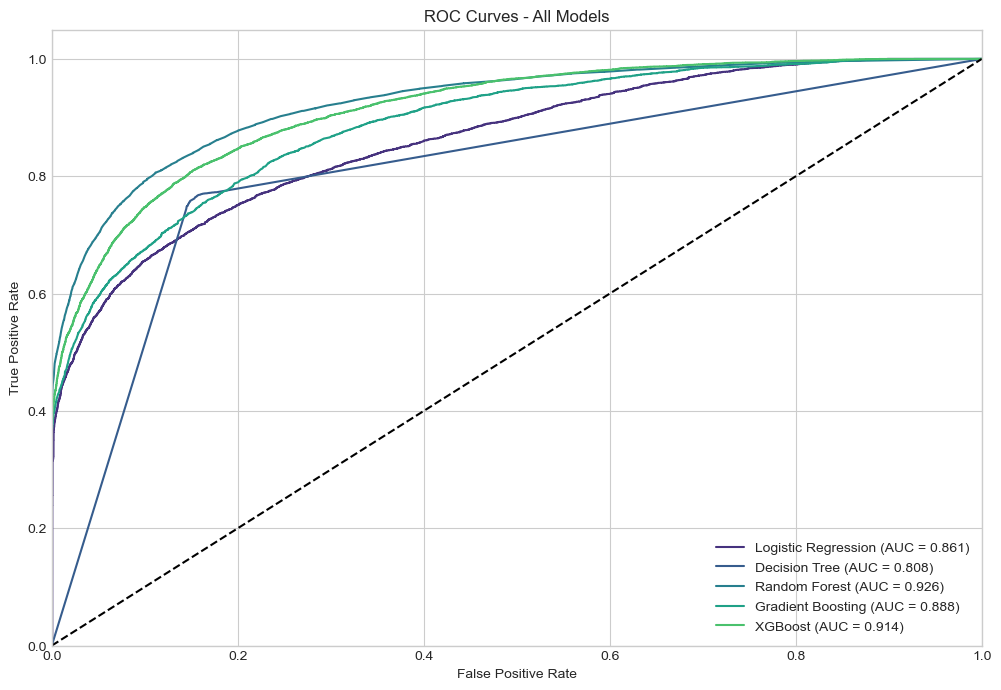

In [47]:
# Plot ROC curves for all models
plt.figure(figsize=(12, 8))
for model_name, (y_pred, y_pred_proba) in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc='lower right')
plt.show()

## 11. Handling Class Imbalance with SMOTE

In [48]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)

# Get preprocessed data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Display class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts(normalize=True) * 100)


Class distribution after SMOTE:
is_canceled
0    50.0
1    50.0
Name: proportion, dtype: float64


In [49]:
# Train XGBoost on SMOTE-resampled data
xgb_smote = XGBClassifier(n_estimators=100, random_state=42)
xgb_smote.fit(X_train_smote, y_train_smote)

# Predict on test set
X_test_preprocessed = preprocessor.transform(X_test)
y_pred_xgb_smote = xgb_smote.predict(X_test_preprocessed)
y_pred_proba_xgb_smote = xgb_smote.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate performance
print("\n--- XGBoost with SMOTE Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_smote):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb_smote):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb_smote):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_xgb_smote):.4f}")


--- XGBoost with SMOTE Performance ---
Accuracy: 0.8440
Precision: 0.8079
Recall: 0.7595
F1 Score: 0.7830
ROC AUC: 0.9130


In [50]:
# Compare regular XGBoost vs XGBoost with SMOTE
comparison_smote = pd.DataFrame({
    'XGBoost': [accuracy_score(y_test, y_pred_xgb), 
               precision_score(y_test, y_pred_xgb),
               recall_score(y_test, y_pred_xgb),
               f1_score(y_test, y_pred_xgb),
               roc_auc_score(y_test, y_pred_proba_xgb)],
    'XGBoost + SMOTE': [accuracy_score(y_test, y_pred_xgb_smote),
                       precision_score(y_test, y_pred_xgb_smote),
                       recall_score(y_test, y_pred_xgb_smote),
                       f1_score(y_test, y_pred_xgb_smote),
                       roc_auc_score(y_test, y_pred_proba_xgb_smote)]
}, index=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

print("\n--- XGBoost vs XGBoost with SMOTE ---")
print(comparison_smote)


--- XGBoost vs XGBoost with SMOTE ---
            XGBoost  XGBoost + SMOTE
Accuracy   0.843454         0.844041
Precision  0.848220         0.807937
Recall     0.703222         0.759525
F1 Score   0.768945         0.782984
ROC AUC    0.913668         0.913037


## 12. Model Interpretation with SHAP

In [51]:
# Get one model for interpretation (best performing model)
best_model = xgb_pipeline

# Get preprocessed data for interpretation
X_test_preprocessed = preprocessor.transform(X_test)

# Calculate SHAP values
explainer = shap.Explainer(best_model[-1])
shap_values = explainer(X_test_preprocessed)

# Get feature names after preprocessing
preprocessor.fit(X_train)
transformed_features = []
for name, trans, cols in preprocessor.transformers_:
    if hasattr(trans, 'get_feature_names_out'):
        transformed_features.extend(trans.get_feature_names_out(cols))
    else:
        transformed_features.extend(cols)

c:\Users\Oscar\miniconda3\envs\ads\lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


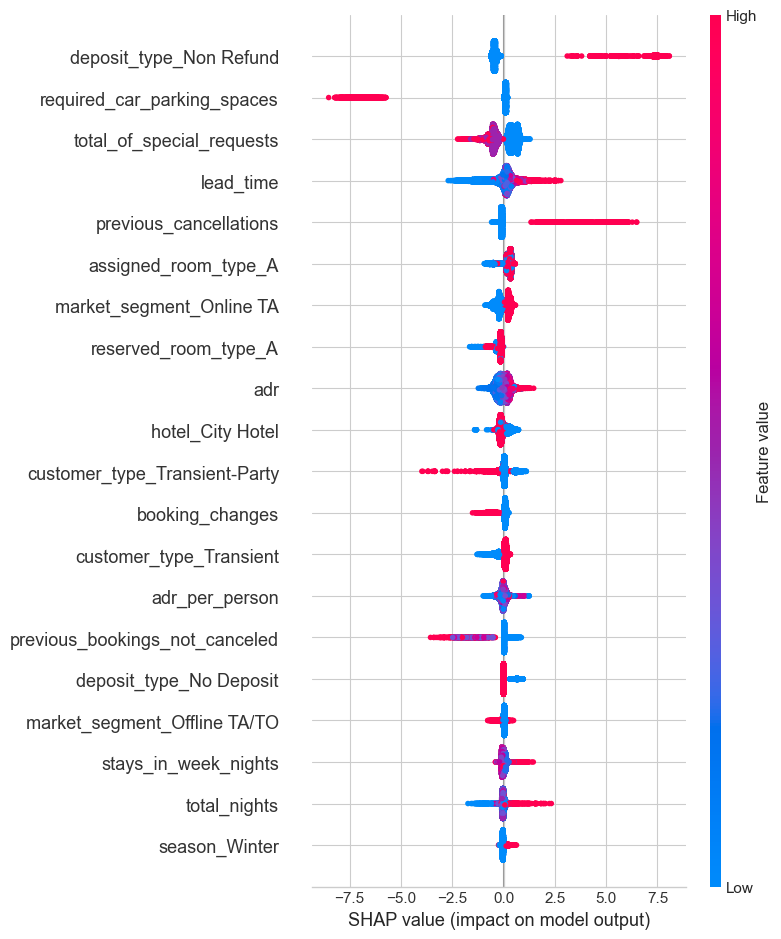

In [52]:
# SHAP summary plot
shap.summary_plot(shap_values.values, X_test_preprocessed, feature_names=transformed_features)

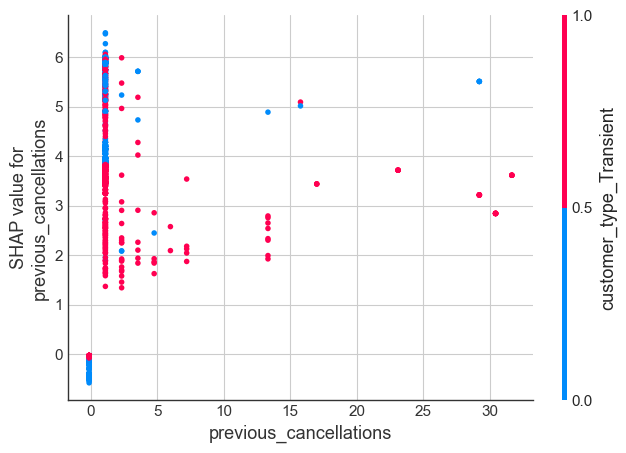

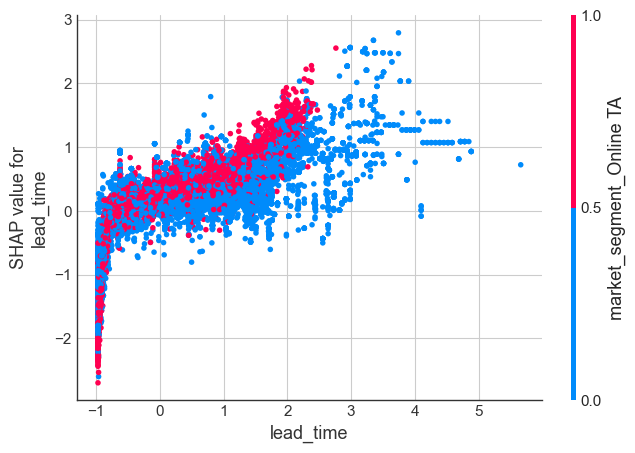

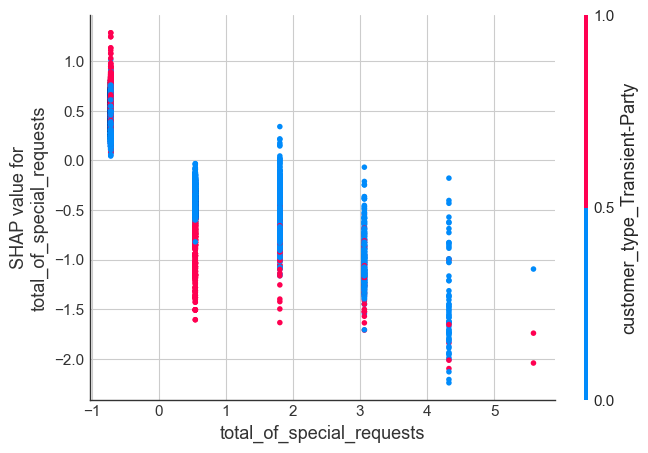

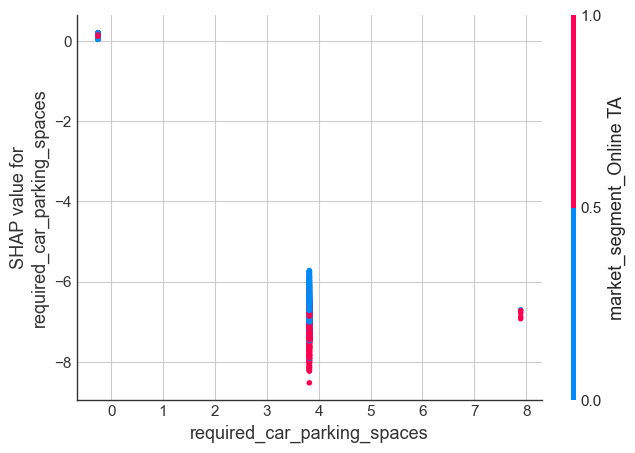

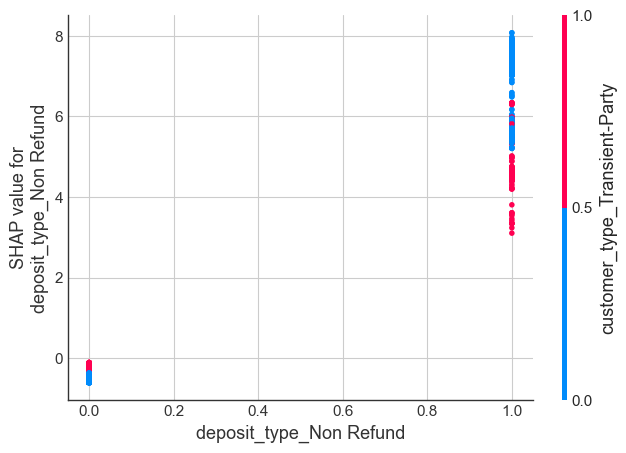

In [53]:
# Dependence plots for top features
top_features = [transformed_features[i] for i in np.argsort(np.abs(shap_values.values).mean(0))[-5:]]
for feature in top_features:
    feature_idx = transformed_features.index(feature)
    shap.dependence_plot(feature_idx, shap_values.values, X_test_preprocessed, 
                        feature_names=transformed_features)